# 태깅

- 자연어 처리 분야에서 각 단어가 어떤 유형에 속해있는지를 알아내는 작업
- 단어 태깅 작업의 대표적인 예시 :
  - 각 단어의 유형이 사람, 장소, 단체 등 어떤 유형인지를 알아내는 **개체명 인식(Named Entity Recognition)**
  - 각 단어의 품사가 명사, 동사, 형용사 인지를 알아내는 **품사 태깅(Part-of-Speech Tagging)**

<br>

<br>

## 태깅 with Keras
- **태깅작업은 지도학습**

<br>

### 훈련 데이터
- 태깅을 해야하는 단어 : $X$
- 레이블에 해당하는 태깅정보 : $y$

<br>

#### $X$와 $y$ 데이터의 쌍(pair)은 병렬구조

- 예)

| # | X_train | y_train | 길이 |
| - | - | - | - |
| 0 | ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb'] | ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O'] | 8 |
| 1 |['peter', 'blackburn'] |['B-PER', 'I-PER'] | 2 |
| 2 |['brussels', '1996-08-22' ] |['B-LOC', 'O'] | 2 |
| 3 |['The', 'European', 'Commission'] |	['O', 'B-ORG', 'I-ORG'] | 3 |

<br>

- X_train[3]의 'The'와 y_train[3]의 'O'는 하나의 쌍(pair)
- X_train[3]의 'European'과 y_train[3]의 'B-ORG'는 쌍의 관계를 가지며, X_train[3]의 'Commision'과 y_train[3]의 'I-ORG'는 쌍의 관계
- **병렬 관계를 가지는 토큰화가 이루어진 데이터는 정수 인코딩 과정을 거친 후, 모든 데이터의 길이를 동일하게 맞춰주기위한 패딩(Padding) 작업을 거친 후에 딥 러닝 모델의 입력으로 사용**

<br>

### 시퀀스 레이블링(Sequence Labeling)
- **시퀀스 X = [$x_1, x_2, x_3 ..., x_n$]에 대하여 레이블 시퀀스 y = [$y_1, y_2, y_3, ..., y_n$]를 각각 부여하는 작업을 시퀀스 레이블링 작업(Sequence Labeling Task)**
  - 태깅 작업은 대표적인 시퀀스 레이블링 작업

<br>

### 양방향 LSTM(Bidirectional LSTM)
- 이전 시점의 단어 정보 뿐만 아니라, 다음 시점의 단어 정보도 참고하기 위하여 양방향 LSTM 사용

<br>

### RNN의 다-대-다(Many-to-Many) 문제
![many_to_one[1].PNG](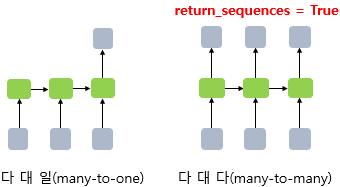)

<br>

- RNN의 은닉층은 모든 시점에 대해서 은닉 상태의 값을 출력할 수도, 마지막 시점에 대해서만 은닉 상태의 값을 출력할 수도 있음
- 인자로 `return_sequences=True`를 넣을 것인지, 넣지 않을 것인지로(넣지 않으면 기본값은 False이므로 `return_sequences=False`로 인식.) 설정할 수 있으며,

  **태깅 작업의 경우에는 다 대 다(many-to-many) 문제로 `return_sequences=True`를 설정하여 출력층에 모든 은닉 상태의 값을 보냄**

<br>

- 위의 데이터 중 첫번째 데이터에 해당되는 X_train[0]를 가지고 4번의 시점(time steps)까지 RNN을 진행하였을 때의 그림

  ![forwardrnn_ver2[1].PNG](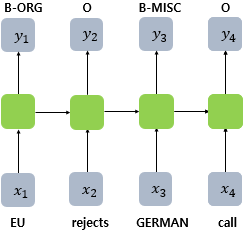)

<br>

- 양방향 RNN을 사용하였을 때의 그림

  ![bidirectionalrnn_ver2[1].PNG](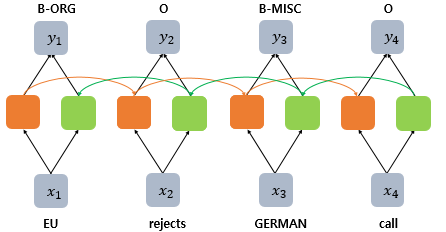)

<br>

<br>

## 양방향 LSTM를 이용한 품사 태깅(Part-of-speech Tagging using Bi-LSTM)

In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split

In [2]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

<br>

### 품사태깅 데이터

-  문장 샘플의 개수를 확인
- 토큰화에 품사 태깅이 된 데이터 받아오기

In [3]:
tagged_sentences = nltk.corpus.treebank.tagged_sents()
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences))

품사 태깅이 된 문장 개수:  3914


In [4]:
tagged_sentences[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

<br>

- 품사 태깅 전처리가 수행된 문장이 총 3,914개
- **훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 품사 태깅 정보에 해당되는 부분을 분리시켜야 함**
  - **[('Pierre', 'NNP'), ('Vinken', 'NNP')]와 같은 문장 샘플이 있다면 Pierre과 Vinken을 같이 저장하고, NNP와 NNP를 같이 저장**

In [5]:
sentences, pos_tags = [], []

for tagged_sentence in tagged_sentences:

    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 품사 태깅 정보들은 tag_info에 저장
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장
    pos_tags.append(list(tag_info)) # 각 샘플에서 품사 태깅 정보만 저장

In [6]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


<br>

#### 데이터의 길이 분포 확인
- 위의 그래프는 대부분의 샘플의 길이가 150 이내며 대부분 0~50의 길이를 가짐

샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


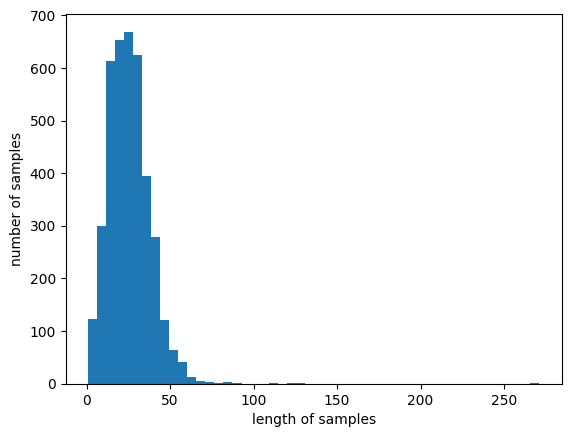

In [7]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))

plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

<br>

#### 정수 인코딩

In [8]:
def tokenize(samples):

  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(samples)

  return tokenizer

In [9]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

In [10]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1

print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


In [11]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

In [12]:
print(X_train[:1])
print(y_train[:1])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9]]


<br>

#### 패딩
- 150의 길이로 패딩

In [13]:
max_len = 150

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

<br>

#### 훈련/테스트 데이터 분리

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [15]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150)


<br>

### 양방향 LSTM(Bi-directional LSTM)으로 POS Tagger 만들기



In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

<br>

- 각 데이터의 길이가 달라서 패딩을 하느라 숫자 0이 많아질 경우에는 `Embedding()`에 `mask_zero=True`를 설정

  $→$ 숫자 0은 연산에서 제외시킨다는 옵션

<br>

#### `tensorflow.keras.layers.TimeDistributed(layer)`
- 다-대-다(Many-to-Many) 출력
- **TimeDistributed()는 LSTM을 다 대 다 구조로 사용하여 LSTM의 모든 시점에 대해서 출력층을 사용할 필요가 있을 때 사용**

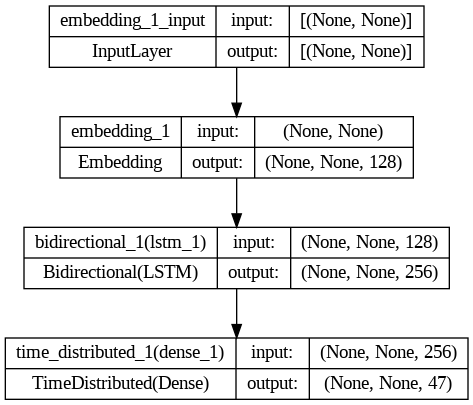

In [18]:
embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))

plot_model(model, show_shapes=True)

<br>

#### 모델 학습

In [19]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=7, validation_data=(X_test, y_test), verbose=False)

<br>

#### 모델 평가

In [21]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

25/25 [==============================] - 0s 8ms/step - loss: 0.3956 - accuracy: 0.9052

 테스트 정확도: 0.9052


<br>

In [22]:
index_to_word = src_tokenizer.index_word
index_to_tag = tar_tokenizer.index_word

In [23]:
i = 10

y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측값 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 레이블로 변환

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], y_test[i], y_predicted[0]):

    if word != 0: # PAD값은 제외함.

        print("{:17}: {:7} {}".format(index_to_word[word], index_to_tag[tag].upper(), index_to_tag[pred].upper()))

1/1 [==============================] - 3s 3s/step
단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      RB
respected        : VBN     VBN
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .


<br>

<br>

### 개체명 인식(Named Entity Recognition)
- 코퍼스로부터 각 개체(entity)의 유형을 인식
- 개체명 인식을 사용하면 코퍼스로부터 어떤 단어가 사람, 장소, 조직 등을 의미하는 단어인지를 찾을 수 있음

<br>

#### 개체명 인식(Named Entity Recognition)이란?
- **개체명 인식(Named Entity Recognition)이란 말 그대로 이름을 가진 개체(named entity)를 인식**
  - 어떤 이름을 의미하는 단어를 보고는 그 단어가 어떤 유형인지를 인식하는 것

  ```
  유정 - 사람
  2018년 - 시간
  골드만삭스 - 조직
  ```

<br>

### NLTK를 이용한 개체명 인식(Named Entity Recognition using NTLK)

- **NLTK에서는 개체명 인식기(NER chunker)를 지원하고 있으므로**, 별도 개체명 인식기를 구현할 필요없이 NLTK를 사용해서 개체명 인식을 수행 가능

In [27]:
from nltk import word_tokenize, pos_tag, ne_chunk

In [33]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

<br>

#### `nltk.pos_tag()` : 품사 태깅

<br>

* 토큰화 후 품사 태깅

In [34]:
sentence = "James is working at Disney in London"

tokenized_sentence = pos_tag(word_tokenize(sentence))
print(tokenized_sentence)

[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]


<br>

#### `nltk.ne_chunk` : 개체명 인식
- **`nltk.ne_chunk`는 개체명을 태깅하기 위해서 앞서 품사 태깅(pos_tag)이 수행되어야 함**
* James는 PERSON(사람), Disney는 조직(ORGANIZATION), London은 위치(GPE)라고 정상적으로 개체명 인식이 수행



In [36]:
ner_sentence = ne_chunk(tokenized_sentence)

print(ner_sentence)

(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


<br>

<br>

## 개체명 인식의 BIO 표현
- 개체명 인식은 챗봇 등에서 필요한 주요 전처리 작업이면서 그 자체로도 까다로운 작업
- **도메인 또는 목적에 특화되도록 개체명 인식을 정확하게 하는 방법 중 하나는 기존에 공개된 개체명 인식기를 사용하는 것이 아니라, 직접 목적에 맞는 데이터를 준비하여 모델을 만드는 것**

<br>

### BIO 표현
- **개체명 인식에서 코퍼스로부터 개체명을 인식하기 위한 가장 보편적인 방법 중 하나인 BIO 태깅**
  - **B는 Begin의 약자로 개체명이 시작되는 부분 **
  - **I는 Inside의 약자로 개체명의 내부 부분**
  - **O는 Outside의 약자로 개체명이 아닌 부분**

<br>

- 영화 제목이 시작되는 글자인 '해'에서는 B가 사용
- 영화 제목이 끝나는 순간까지 I가 사용
- 영화 제목이 아닌 부분에 대해서만 O가 사용
- **이처럼 B와 I는 개체명을 위해 사용되고, O는 개체명이 아니라는 의미**


  ```
  해 B
  리 I
  포 I
  터 I
  보 O
  러 O
  가 O
  자 O

  ```

<br>

- **개체명 인식이라는 것은 보통 한 종류의 개체에 대해서만 언급하는 것이 아니라 여러 종류의 개체가 있을 수 있음**
  - 예) 영화에 대한 대화에서는 영화 제목에 대한 개체명과 극장에 대한 개체명

  <br>

  ```
  해 B-movie
리 I-movie
포 I-movie
터 I-movie
보 O
러 O
메 B-theater
가 I-theater
박 I-theater
스 I-theater
가 O
자 O
  ```

<br>

### 개체명 인식 데이터 이해
- CONLL2003은 개체명 인식을 위한 전통적인 영어 데이터셋
  - 데이터의 형식은 `[단어]` `[품사 태깅]` `[청크 태깅]` `[개체명 태깅]`의 형식
  - **품사 태깅 :** https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    - 예) EU 옆에 붙어있는 NNP는 고유 명사 단수형을 의미하며, rejects 옆에 있는 VBZ는 3인칭 단수 동사 현재형을 의미
  - **개체명 태깅 :**

    **LOC는 location**

    **ORG는 organization**

    **PER은 person**

    **MISC는 miscellaneous**

    해당 데이터는 BIO 표현 방법을 사용하고 있기 때문에, 개체명의 시작 부분이면서 Organization을 의미하는 EU에는 B-ORG라는 개체명 태깅

    다만, EU 그 자체로 개체명 하나이기 때문에 거기서 개체명 인식은 종료되면서 뒤에 I가 별도로 붙는 단어가 나오지는 않음.

    이에 EU 뒤에 나오는 call은 개체명이 아니기 때문에 O가 태깅
- 9번째 줄인`. . O O` 다음에 11번째 줄 Peter가 나오는 부분 사이에서 10번째 줄은 공란 :

  9번째 줄에서 문장이 끝나고 11번째 줄에서 새로운 문장이 시작됨을 의미

- 그 다음 문장이 시작되는 11번째 줄에서는 개체명이 하나의 단어로 끝나지 않았을 때, 어떻게 다음 단어로 개체명 인식이 이어지는지를 보여줌 :

  Peter는 개체명이 시작되면서 person에 해당되기 때문에 B-PER이라는 개체명 태깅

  그리고 아직 개체명에 대한 인식은 끝나지 않았기 때문에 뒤에 붙는 Blackburn에서는 I가 나오면서 I-PER이 개체명 태깅으로 붙게 됨

  **즉, Peter Blackburn이 person에 속하는 하나의 개체명**

  ```
  EU NNP B-NP B-ORG
  rejects VBZ B-VP O
  German JJ B-NP B-MISC
  call NN I-NP O
  to TO B-VP O
  boycott VB I-VP O
  British JJ B-NP B-MISC
  lamb NN I-NP O
  . . O O

  Peter NNP B-NP B-PER
  Blackburn NNP I-NP I-PER
  ```

<br>

### 데이터 로드 & 전처리

In [37]:
import re
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [38]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20RNN%20Sequence%20Labeling/dataset/train.txt", filename="train.txt")

('train.txt', <http.client.HTTPMessage at 0x7f4571233160>)

In [39]:
f = open('train.txt', 'r')

tagged_sentences = []
sentence = []

In [40]:
for line in f:

    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue

    splits = line.split(' ') # 공백을 기준으로 속성을 구분
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록

In [41]:
print("전체 샘플 개수: ", len(tagged_sentences))

전체 샘플 개수:  14041


In [42]:
print('첫번째 샘플 :',tagged_sentences[0])

첫번째 샘플 : [['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


<br>

- 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 개체명 태깅 정보에 해당되는 부분을 분리
  - 즉, [('eu', 'B-ORG'), ('rejects', 'O')]와 같은 문장 샘플이 있다면,

     eu와 rejects는 같이 저장하고, B-ORG와 O를 같이 저장

In [43]:
sentences, ner_tags = [], []

for tagged_sentence in tagged_sentences:

    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장

In [44]:
print('첫번째 샘플의 문장 :',sentences[0])
print('첫번째 샘플의 레이블 :',ner_tags[0])

첫번째 샘플의 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
첫번째 샘플의 레이블 : ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


<br>

#### 데이터 길이 분포
- 위의 그래프는 샘플들의 길이가 대체적으로 0~40의 길이를 가지며, 특히 0~20의 길이를 가진 샘플이 상당한 비율을 차지
- 길이가 가장 긴 샘플의 길이는 113

샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


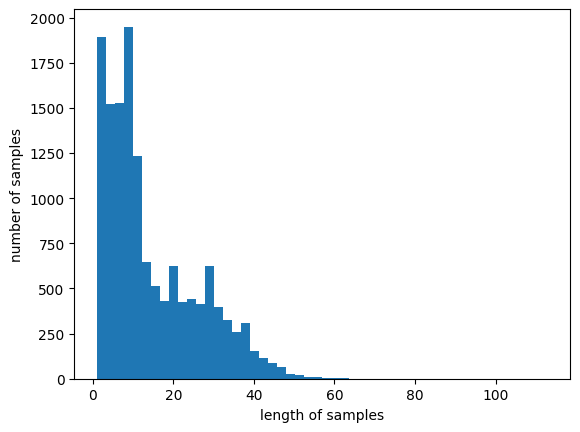

In [45]:
print('샘플의 최대 길이 : %d' % max(len(sentence) for sentence in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))

plt.hist([len(sentence) for sentence in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

<br>

### 정수 인코딩
- 문장 데이터에 있는 모든 단어를 사용하지 않고 높은 빈도수를 가진 상위 약 4,000개의 단어만을 사용

In [46]:
vocab_size = 4000

src_tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [47]:
tag_size = len(tar_tokenizer.word_index) + 1

print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 : 10


In [48]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [49]:
print('첫번째 샘플의 문장 :',X_train[0])
print('첫번째 샘플의 레이블 :',y_train[0])

첫번째 샘플의 문장 : [989, 1, 205, 629, 7, 3939, 216, 1, 3]
첫번째 샘플의 레이블 : [4, 1, 7, 1, 1, 1, 7, 1, 1]


<br>

- **현재 문장 데이터에 대해서는 일부 단어가 'OOV'로 대체됨을 확인**

In [50]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [51]:
decoded = []

for index in X_train[0] :
    decoded.append(index_to_word[index])

print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


<br>

### 패딩
- 70의 길이로 패딩


In [52]:
max_len = 70

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

<br>

#### 훈련/테스트 데이터 분리

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

<br>

#### 레이블에 대하여 원-핫 인코딩

In [54]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [55]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2809, 70)
테스트 샘플 레이블의 크기 : (2809, 70, 10)


<br>

### 양방향 LSTM(Bi-directional LSTM)으로 개체명 인식기 생성

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

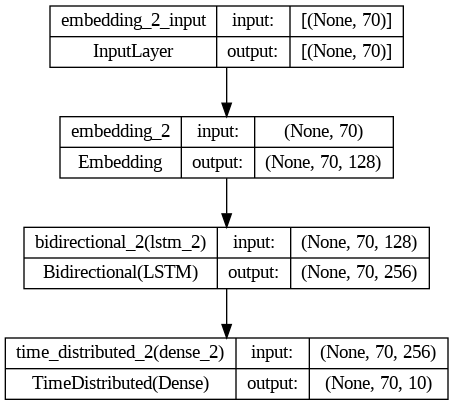

In [57]:
embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

plot_model(model, show_shapes=True)

In [59]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=8, validation_data=(X_test, y_test),
          verbose=False)

<br>

### 모델 평가

In [60]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

88/88 [==============================] - 1s 6ms/step - loss: 0.1629 - accuracy: 0.9562

 테스트 정확도: 0.9562


In [61]:
i = 10

y_predicted = model.predict(np.array([X_test[i]]))
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 레이블로 변경.
labels = np.argmax(y_test[i], -1) # 원-핫 벡터를 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):

    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag].upper(), index_to_ner[pred].upper()))

1/1 [==============================] - 2s 2s/step
단어             |실제값  |예측값
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   I-PER
,                : O       O
whose            : O       O
republican       : B-MISC  B-MISC
husband          : O       O
was              : O       O
OOV              : O       O
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   B-PER
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  I-MISC
convention       : I-MISC  I-MISC
on               : O       O
monday           : O       O
night            : O       O
to         